You can run this notebook in a [live session](https://binder.pangeo.io/v2/gh/pangeo-data/climpred/main?urlpath=lab/tree/docs/source/examples/subseasonal/daily-subx-example.ipynb) [<img src="https://mybinder.org/badge_logo.svg" alt='binder badge'>](https://binder.pangeo.io/v2/gh/pangeo-data/climpred/main?urlpath=lab/tree/docs/source/examples/subseasonal/daily-subx-example.ipynb) or view it [on Github](https://github.com/pangeo-data/climpred/blob/main/docs/source/examples/subseasonal/daily-subx-example.ipynb).

## Calculate skill of a MJO Index of SubX model GEOS_V2p1 as function of daily lead time 

In this example, we demonstrate: 

1. How to remotely access data from the Subseasonal Experiment (SubX) hindcast database and set it up to be used in `climpred`. 
2. How to calculate the Anomaly Correlation Coefficient (ACC) using daily data with `climpred`
3. How to calculate and plot historical forecast skill of the real-time multivariate MJO (RMM) indices as function of lead time.

### The Subseasonal Experiment (SubX)

Further information on SubX is available from {cite:t}`Pegion2019` and the [SubX project website](http://cola.gmu.edu/subx/).

The SubX public database is hosted on the International Research Institute for Climate and Society (IRI) data server [http://iridl.ldeo.columbia.edu/SOURCES/.Models/.SubX/](http://iridl.ldeo.columbia.edu/SOURCES/.Models/.SubX/).

Since the SubX data server is accessed via this notebook, the time for the notebook to run may is several minutes and will vary depending on the speed that data can be downloaded. This is a large dataset, so please be patient. If you prefer to download SubX data locally, scripts are available from [https://github.com/kpegion/SubX](https://github.com/kpegion/SubX.).

### Definitions

**RMM**
: Two indices (RMM1 and RMM2) are used to represent the MJO. Together they define the MJO based on 8 phases and can represent both the phase and amplitude of the MJO {cite:p}`Wheeler2004`. This example uses the observed RMM1 provided by Matthew Wheeler at the Center for Australian Weather and Climate Research. It is the version of the indices in which interannual variability has not been removed.

**Skill of RMM**
: Traditionally, the skill of the RMM is calculated as a bivariate correlation encompassing the skill of the two indices together {cite:p}`Rashid2011,Gottschalck2010`.  Currently, `climpred` does not have the functionality to calculate the bivariate correlation, thus the anomaly correlation coefficient for RMM1 index is calculated here as a demonstration.  The bivariate correlation metric will be added in a future version of `climpred`.

In [1]:
# linting
%load_ext nb_black
%load_ext lab_black

<IPython.core.display.Javascript object>

In [2]:
import warnings

import matplotlib.pyplot as plt

import xarray as xr
import pandas as pd
import numpy as np

from climpred import HindcastEnsemble
import climpred

warnings.filterwarnings("ignore")

<IPython.core.display.Javascript object>

Read the observed RMM Indices.

In [3]:
obsds = climpred.tutorial.load_dataset("RMM-INTERANN-OBS")[["rmm1"]].dropna(
    "time"
)  # Get rid of missing times.

<IPython.core.display.Javascript object>

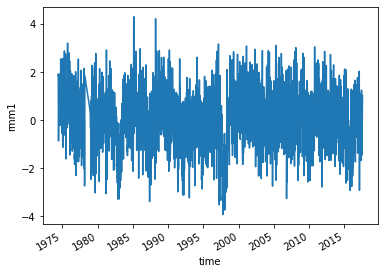

<IPython.core.display.Javascript object>

In [4]:
obsds["rmm1"].plot()

Read the SubX RMM1 data for the `GMAO-GEOS_V2p1` model from the SubX data server.  It is important to note that the SubX data contains weekly initialized forecasts where the `init` day varies by model.  SubX data may have all NaNs for initial dates in which a model does not make a forecast, thus we apply `dropna` over the `S=init` dimension when `how=all` data for a given `S=init` is missing.  This can be slow, but allows the rest of the calculations to go more quickly. 

Note that we ran the `dropna` operation offline and then uploaded the post-processed SubX dataset to the `climpred-data` repo for the purposes of this demo. This is how you can do this manually:

```python
url = 'http://iridl.ldeo.columbia.edu/SOURCES/.Models/.SubX/.GMAO/.GEOS_V2p1/.hindcast/.RMM/.RMM1/dods/'
fcstds = xr.open_dataset(url, decode_times=False, chunks={'S': 1, 'L': 45}).dropna(dim='S',how='all')
```

In [5]:
fcstds = climpred.tutorial.load_dataset("GMAO-GEOS-RMM1", decode_times=False)
fcstds

<xarray.Dataset>
Dimensions:  (S: 510, M: 4, L: 45)
Coordinates:
  * S        (S) float32 1.424e+04 1.425e+04 1.426e+04 ... 2.044e+04 2.045e+04
  * M        (M) float32 1.0 2.0 3.0 4.0
  * L        (L) float32 0.5 1.5 2.5 3.5 4.5 5.5 ... 40.5 41.5 42.5 43.5 44.5
Data variables:
    RMM1     (S, M, L) float32 ...
Attributes:
    Conventions:  IRIDL

<IPython.core.display.Javascript object>

The SubX data dimensions correspond to the following `climpred` dimension definitions: `X=lon`,`L=lead`,`Y=lat`,`M=member`, `S=init`.  We will rename the dimensions to their `climpred` names.

In [6]:
fcstds = fcstds.rename({"S": "init", "L": "lead", "M": "member", "RMM1": "rmm1"})

<IPython.core.display.Javascript object>

Let's make sure that the `lead` dimension is set properly for `climpred`.  SubX data stores `leads` as 0.5, 1.5, 2.5, etc, which correspond to 0, 1, 2, ... days since initialization. We will change the `lead` to be integers starting with zero. 

In [7]:
fcstds["lead"] = (fcstds["lead"] - 0.5).astype("int")

<IPython.core.display.Javascript object>

Now we need to make sure that the `init` dimension is set properly for `climpred`. We use the `xarray` convenience function `decode_cf` to convert the numeric time into datetimes. It recognizes that this is on a 360 day calendar.

In [8]:
fcstds = xr.decode_cf(fcstds, decode_times=True)

<IPython.core.display.Javascript object>

`climpred` also requires that `lead` dimension has an attribute called `units` indicating what time units the `lead` is assocated with.  Options are: `years`, `seasons`, `months`, `weeks`, `pentads`, `days`, `hours`, `minutes`, or `seconds`.  For the SubX data, the `lead` `units` are `days`. 

In [9]:
fcstds["lead"].attrs = {"units": "days"}

<IPython.core.display.Javascript object>

Create the {py:class}`.HindcastEnsemble` object and {py:meth}`.HindcastEnsemble.add_observations`.

In [11]:
hindcast = HindcastEnsemble(fcstds).add_observations(obsds)
hindcast

Calculate the Anomaly Correlation Coefficient (ACC) {py:func}`.climpred.metrics._pearson_r`

In [12]:
skill = hindcast.verify(
    metric="acc", comparison="e2o", dim="init", alignment="maximize"
)
skill

<xarray.Dataset>
Dimensions:  (lead: 45)
Coordinates:
  * lead     (lead) int64 0 1 2 3 4 5 6 7 8 9 ... 35 36 37 38 39 40 41 42 43 44
    skill    <U11 'initialized'
Data variables:
    rmm1     (lead) float64 0.9782 0.9719 0.9632 0.9508 ... 0.304 0.2801 0.2616
Attributes:
    Conventions:                   IRIDL
    prediction_skill_software:     climpred https://climpred.readthedocs.io/
    skill_calculated_by_function:  HindcastEnsemble.verify()
    number_of_initializations:     510
    number_of_members:             4
    alignment:                     maximize
    metric:                        pearson_r
    comparison:                    e2o
    dim:                           init
    reference:                     []

<IPython.core.display.Javascript object>

Plot the skill as a function of lead time

Text(0, 0.5, 'ACC')

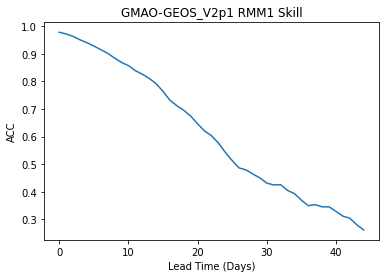

<IPython.core.display.Javascript object>

In [13]:
skill["rmm1"].plot()
plt.title("GMAO-GEOS_V2p1 RMM1 Skill")
plt.xlabel("Lead Time (Days)")
plt.ylabel("ACC")

### References

```{eval-rst}
.. bibliography::
   :filter: docname in docnames
```